In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import plotly.express as px
import scipy.stats as st

In [2]:
raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')#, dtype=str)

/tmp/ipykernel_15298/3955214045.py:1: DtypeWarning: Columns (0,19,20,24,25,26,28,35,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')#, dtype=str)


In [3]:
def filter_col_by_mising_data_pct(df, pct_min=0, pct_max=100):
    result = pd.DataFrame()
    print("Le DataFrame à filtrer présente", len(df), "lignes et", len(df.columns), "colonnes.")
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de", pct_min, "% à", pct_max, "%.")
    # extraction des colonnes remplissant la condition de filtrage
    temp_list_col = round(df.isnull().mean()*100, 4).sort_values(ascending=False)
    temp_list_col = pd.DataFrame(temp_list_col, columns = ["%"])
    temp_list_col = temp_list_col.loc[(temp_list_col["%"] >= pct_min) & (temp_list_col["%"] <= pct_max), :]
    print("Après filtrage, il reste", len(temp_list_col), "colonnes dans le DataFrame.")
    
    # test sur le nb de colonnes restantes
    if len(temp_list_col) == 0:
        print("Le filtre est trop bas. Il n'y a plus de colonnes à exploiter.")
        return result
    
    # renvoyer le même dataset avec uniquement les colonnes filtrées
    result = df[temp_list_col.index]
    return result

In [4]:
# pour changer la lettre du nutriscore en chiffre
code = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5}
raw_data['nutrition_grade_fr'] =raw_data['nutrition_grade_fr'].replace(code).astype(np.float64)
raw_data['nutrition_grade_fr'].unique()

array([nan,  4.,  2.,  3.,  1.,  5.])

In [5]:
col_to_use = [
    "code", "product_name", "main_category_fr", "pnns_groups_1", "pnns_groups_2",
    "nutrition_grade_fr", "nutrition-score-fr_100g"
]
valeurs_manquantes2 = round(raw_data[col_to_use].isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df2 = pd.DataFrame(valeurs_manquantes2, columns = ["%"])
print(missing_val_df2)

                               %
main_category_fr         73.6900
pnns_groups_1            71.4618
pnns_groups_2            70.5333
nutrition_grade_fr       31.0261
nutrition-score-fr_100g  31.0261
product_name              5.5377
code                      0.0000


In [6]:
boissons = raw_data.loc[raw_data["pnns_groups_1"] == "Beverages", :]
fromages = raw_data.loc[raw_data["pnns_groups_2"] == "Cheese", :]
mat_grasses = raw_data.loc[raw_data["pnns_groups_2"] == "Fats", :]
produits_gen = raw_data.loc[(raw_data["pnns_groups_2"] != "Fats") & (raw_data["pnns_groups_2"] != "Cheese") & (raw_data["pnns_groups_1"] != "Beverages"), :]
print("Boissons :", len(boissons))
print("Fromages :", len(fromages))
print("Matières Grasses :", len(mat_grasses))
print("Produits générals :", len(produits_gen))

# for col in ["main_category_fr", "pnns_groups_1", "pnns_groups_2"]:
#     temp_val_count = truc.loc[truc[col].notnull(), col].value_counts(normalize=True)
#     temp_val_count.plot(kind='pie', label='')
#     plt.axis('equal')
#     plt.show()


Boissons : 9033
Fromages : 4024
Matières Grasses : 1614
Produits générals : 306078


In [7]:
col_to_compute_ns = [
    "energy_100g", "saturated-fat_100g", "sugars_100g", "sodium_100g", "salt_100g", "fat_100g", "proteins_100g", "fiber_100g", "fruits-vegetables-nuts_100g"
]

In [8]:
raw_data[col_to_compute_ns].describe()

,energy_100g,saturated-fat_100g,sugars_100g,sodium_100g,salt_100g,fat_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts_100g
count,2.611360e+05,229577.000000,244994.000000,255486.000000,255533.000000,243914.000000,259929.000000,200891.000000,3046.000000
mean,1.141842e+03,5.129562,16.002983,0.798749,2.028455,12.729373,7.076074,2.862048,31.376615
std,6.446875e+03,8.013929,22.326319,50.502155,128.263683,17.578229,8.408824,12.867424,31.947699
min,0.000000e+00,0.000000,-17.860000,0.000000,0.000000,0.000000,-800.000000,-6.700000,0.000000
25%,3.770000e+02,0.000000,1.300000,0.025000,0.063500,0.000000,0.700000,0.000000,0.000000
50%,1.100000e+03,1.790000,5.710000,0.229000,0.581660,5.000000,4.760000,1.500000,22.100000
75%,1.674000e+03,7.140000,24.000000,0.541000,1.374140,20.000000,10.000000,3.600000,50.950000
max,3.251373e+06,550.000000,3520.000000,25320.000000,64312.800000,714.290000,430.000000,5380.000000,100.000000


## Remplir la colonne sodium

In [9]:
missing_na_salt = raw_data.loc[(raw_data["sodium_100g"].isnull()) & (raw_data["salt_100g"].notnull()), :]
print(len(missing_na_salt), "lignes n'ayant pas de sodium mais ayant du sel, soit", round(len(missing_na_salt)/len(raw_data)*100, 2), "% du total.")

47 lignes n'ayant pas de sodium mais ayant du sel, soit 0.01 % du total.


In [10]:
raw_data.loc[:, "sodium_100g"] = raw_data.loc[:, "salt_100g"]/2.5*1000

## Valeurs manquantes

In [11]:
valeurs_manquantes = round(raw_data[col_to_compute_ns].isnull().mean()*100, 1).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df.head(10)

,%
fruits-vegetables-nuts_100g,99.1
fiber_100g,37.4
saturated-fat_100g,28.4
fat_100g,24.0
sugars_100g,23.6
sodium_100g,20.3
salt_100g,20.3
proteins_100g,19.0
energy_100g,18.6


# Discrétisation des composants du nutri-score

In [12]:
fruits_vegetables_nuts_scale = {
    '0': [-1, 40], 
    '1': [40, 60],
    '2': [60, 80],
    '5': [80, 100]}
for key, value in fruits_vegetables_nuts_scale.items():
    raw_data.loc[(raw_data["fruits-vegetables-nuts_100g"] > value[0]) & (raw_data["fruits-vegetables-nuts_100g"] <= value[1]), "fruits-vegetables-nuts_index"] = int(key)

In [13]:
fiber_scale = {
    '0': [-10, 0.9], 
    '1': [0.9, 1.9],
    '2': [1.9, 2.8],
    '3': [2.8, 3.7],
    '4': [3.7, 4.7],
    '5': [4.7, 6000],
}
for key, value in fiber_scale.items():
    raw_data.loc[(raw_data["fiber_100g"] > value[0]) & (raw_data["fiber_100g"] <= value[1]), "fiber_index"] = int(key)

In [14]:
saturated_fat_scale = {
    '0': [-1, 1], 
    '1': [1, 2],
    '2': [2, 3],
    '3': [3, 4],
    '4': [4, 5],
    '5': [5, 6],
    '6': [6, 7],
    '7': [7, 8],
    '8': [8, 9],
    '9': [9, 10],
    '10': [10, 600],
}
for key, value in saturated_fat_scale.items():
    raw_data.loc[(raw_data["saturated-fat_100g"] > value[0]) & (raw_data["saturated-fat_100g"] <= value[1]), "saturated-fat_index"] = int(key)

In [15]:
sugars_scale = {
    '0': [-20, 4.5], 
    '1': [4.5, 9],
    '2': [9, 13.5],
    '3': [13.5, 18],
    '4': [18, 22.5],
    '5': [22.5, 27],
    '6': [27, 31],
    '7': [31, 36],
    '8': [36, 40],
    '9': [40, 45],
    '10': [45, 4000],
}
for key, value in sugars_scale.items():
    raw_data.loc[(raw_data["sugars_100g"] > value[0]) & (raw_data["sugars_100g"] <= value[1]), "sugars_index"] = int(key)

In [16]:
sodium_scale = {
    '0': [-1, 90], 
    '1': [90, 180],
    '2': [180, 270],
    '3': [270, 360],
    '4': [360, 450],
    '5': [450, 540],
    '6': [540, 630],
    '7': [630, 720],
    '8': [720, 810],
    '9': [810, 900],
    '10': [900, 26000],
}
for key, value in sodium_scale.items():
    raw_data.loc[(raw_data["sodium_100g"] > value[0]) & (raw_data["sodium_100g"] <= value[1]), "sodium_index"] = int(key)

In [17]:
proteins_scale = {
    '0': [-900, 1.6], 
    '1': [1.6, 3.2],
    '2': [3.2, 4.8],
    '3': [4.8, 6.4],
    '4': [6.4, 8],
    '5': [8, 450],
}
for key, value in proteins_scale.items():
    raw_data.loc[(raw_data["proteins_100g"] > value[0]) & (raw_data["proteins_100g"] <= value[1]), "proteins_index"] = int(key)

In [18]:
energy_scale = {
    '0': [-1, 335], 
    '1': [335, 670],
    '2': [670, 1005],
    '3': [1005, 1340],
    '4': [1340, 1675],
    '5': [1675, 2010],
    '6': [2010, 2345],
    '7': [2345, 2680],
    '8': [2680, 3015],
    '9': [3015, 3350],
    '10': [3350, 600],
}
for key, value in energy_scale.items():
    raw_data.loc[(raw_data["energy_100g"] > value[0]) & (raw_data["energy_100g"] <= value[1]), "energy_index"] = int(key)

colonne : fruits-vegetables-nuts_index
moyenne :  0.8640840446487197
médiane :  0.0
mode :  0    0.0
Name: fruits-vegetables-nuts_index, dtype: float64
min :  0.0
max :  5.0
quartiles :  [nan, nan]
variance :  2.2290646075129157
écart-type :  1.4930052268873393
coefficient de variation :  1.7278472344600437
skewness :  1.9918994546215336
kurtosis :  2.843844580997235


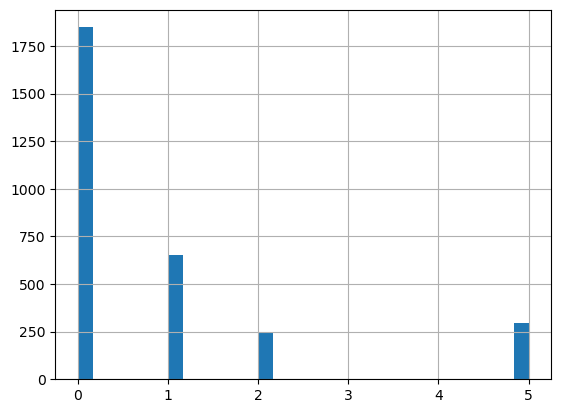

colonne : fiber_index
moyenne :  1.757520247298286
médiane :  1.0
mode :  0    0.0
Name: fiber_index, dtype: float64
min :  0.0
max :  5.0
quartiles :  [nan, nan]
variance :  3.7351216644227345
écart-type :  1.9326462853876636
coefficient de variation :  1.0996438239380666
skewness :  0.6364960665683593
kurtosis :  -1.141393153564445


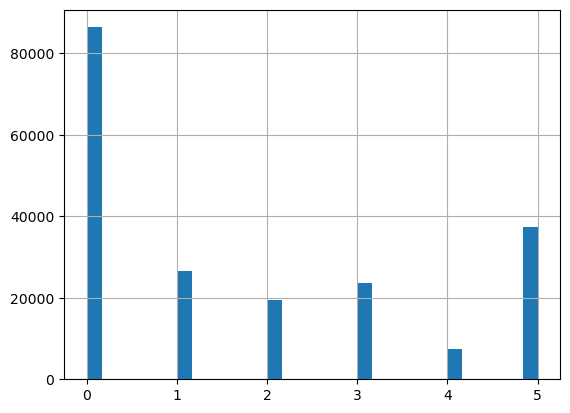

colonne : saturated-fat_index
moyenne :  3.3336484055458517
médiane :  1.0
mode :  0    0.0
Name: saturated-fat_index, dtype: float64
min :  0.0
max :  10.0
quartiles :  [nan, nan]
variance :  15.506401771240412
écart-type :  3.937816878835329
coefficient de variation :  1.18123341150326
skewness :  0.7419152861241577
kurtosis :  -1.0998961316516789


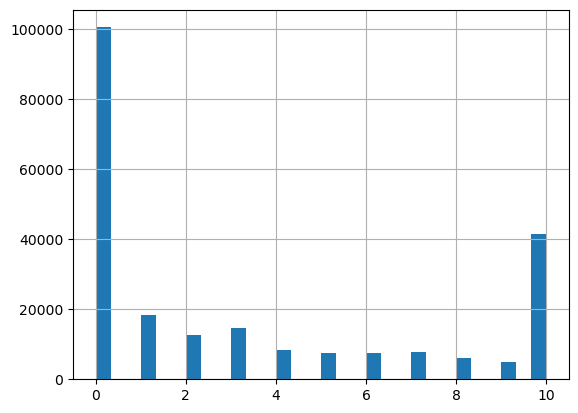

colonne : sugars_index
moyenne :  2.720980921981763
médiane :  1.0
mode :  0    0.0
Name: sugars_index, dtype: float64
min :  0.0
max :  10.0
quartiles :  [nan, nan]
variance :  12.800569866441585
écart-type :  3.577788404369602
coefficient de variation :  1.3148891914184402
skewness :  1.0752329602960997
kurtosis :  -0.37740334486638494


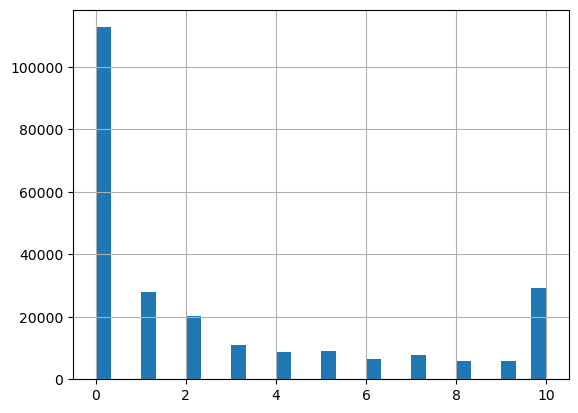

colonne : sodium_index
moyenne :  3.168217249182801
médiane :  2.0
mode :  0    0.0
Name: sodium_index, dtype: float64
min :  0.0
max :  10.0
quartiles :  [nan, nan]
variance :  12.2425572442619
écart-type :  3.498936587630862
coefficient de variation :  1.1043865721434871
skewness :  0.7843177828088631
kurtosis :  -0.7467030695718293


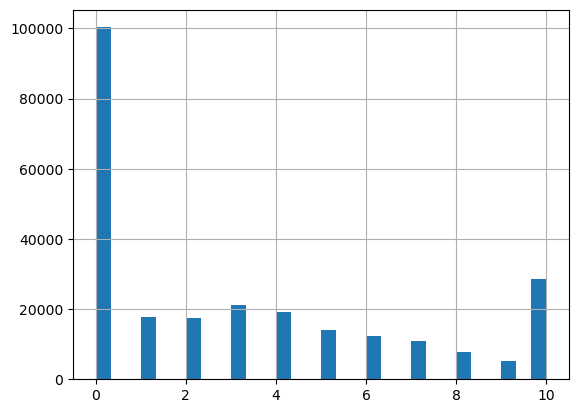

colonne : proteins_index
moyenne :  2.5138518595462607
médiane :  2.0
mode :  0    5.0
Name: proteins_index, dtype: float64
min :  0.0
max :  5.0
quartiles :  [nan, nan]
variance :  4.384521836281526
écart-type :  2.0939249834417484
coefficient de variation :  0.8329548041942665
skewness :  -0.011873314557009924
kurtosis :  -1.6774909312731885


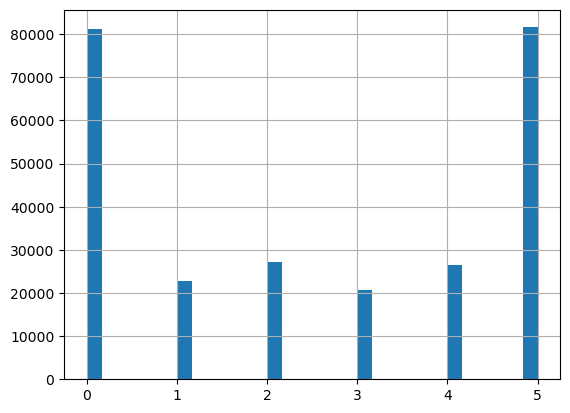

colonne : energy_index
moyenne :  2.8071930386957984
médiane :  3.0
mode :  0    0.0
Name: energy_index, dtype: float64
min :  0.0
max :  9.0
quartiles :  [nan, nan]
variance :  5.120520798883569
écart-type :  2.262856778252563
coefficient de variation :  0.8060923303314652
skewness :  0.3409455035122921
kurtosis :  -0.8423659704702131


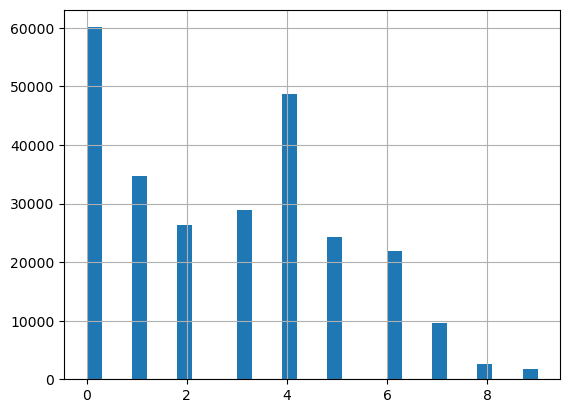

In [19]:
col_index = ["fruits-vegetables-nuts_index", "fiber_index", "saturated-fat_index", "sugars_index", "sodium_index", "proteins_index", "energy_index"]
for col in col_index:
    print("colonne :", col)
    raw_data[col].hist(bins=30)
    # mesures de tendances centrales
    print("moyenne : ", raw_data[col].mean())
    print("médiane : ", raw_data[col].median())
    print("mode : ", raw_data[col].mode())
    print("min : ", raw_data[col].min())
    print("max : ", raw_data[col].max())
    quartiles = [np.percentile(raw_data[col], p) for p in [25, 75]]
    print("quartiles : ", quartiles)
    # mesures de dispersion
    print("variance : ", raw_data[col].var(ddof=0))
    print("écart-type : ", raw_data[col].std(ddof=0))
    print("coefficient de variation : ", raw_data[col].std(ddof=0)/raw_data[col].mean())
    # mesures de forme
    print("skewness : ", raw_data[col].skew())
    print("kurtosis : ", raw_data[col].kurtosis())
    plt.show()

In [20]:
cols_to_keep = ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n", "nutrition-score-fr_100g"] #"nutrition_grade_fr"

In [21]:
df = raw_data[cols_to_keep + col_index]
# remplace valeurs manquantes par la moyenne. pas la meilleure méthode, mais ça ira très bien pour ce TP
df = df.fillna(df.mean())

In [22]:
# faisons un data split
X = df.values # valeurs dans un array X
names = df.index # noms dans names
features = df.columns # les features

In [23]:
# instance de scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# on ne travaille que sur les x premières variables pour l'instant
n_components = 11
# instance de PCA
pca = PCA(n_components=n_components)
# entrainement sur les données scalées
pca.fit(X_scaled)

PCA(n_components=11)

In [25]:
# pour garder les valeurs propres supérieures à 1
pca.explained_variance_

array([2.66743394, 1.63577531, 1.37717691, 1.24266871, 0.99731188,
       0.88439355, 0.74124211, 0.61650363, 0.47595204, 0.27331976,
       0.08825645])

In [26]:
pca.explained_variance_ratio_

array([0.24249324, 0.14870638, 0.12519751, 0.11296953, 0.09066443,
       0.08039916, 0.06738544, 0.05604561, 0.04326823, 0.02484717,
       0.00802329])

In [27]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([24.25, 14.87, 12.52, 11.3 ,  9.07,  8.04,  6.74,  5.6 ,  4.33,
        2.48,  0.8 ])

In [28]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 24.,  39.,  52.,  63.,  72.,  80.,  87.,  92.,  97.,  99., 100.])

In [29]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

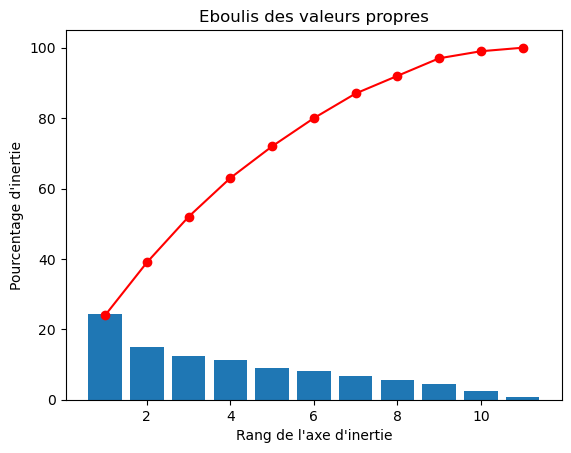

In [30]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [31]:
# voyons les composantes
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7,8,9,10
0,0.088358,0.130267,0.072173,0.529993,-0.027339,0.114016,0.496112,0.280025,0.162666,0.242306,0.515423
1,0.346434,0.148513,0.231386,0.199254,0.007602,-0.397803,0.024075,0.437727,-0.307076,-0.544217,-0.154041
2,0.432656,0.212916,0.436410,0.037563,-0.074631,-0.286844,-0.016816,-0.407742,0.510955,0.173507,-0.173337
3,0.209326,0.429558,0.436062,-0.306104,-0.013068,0.530467,-0.176809,0.100088,-0.344771,0.163792,0.138825
4,0.022658,0.027491,0.046823,0.007737,0.995870,0.005743,0.008761,-0.019076,0.064754,0.000813,0.007322
5,-0.494821,0.770803,-0.123797,0.025589,-0.002699,-0.214979,0.197644,-0.198126,-0.080402,-0.068751,-0.096454
6,-0.409560,-0.367506,0.654096,-0.016154,0.001231,-0.124084,0.338053,-0.229730,-0.294138,-0.004824,0.010146
7,-0.385161,0.025744,0.295129,0.148500,-0.037452,0.353604,-0.255843,0.215584,0.546326,-0.450391,-0.046262
8,0.281049,-0.018340,-0.167452,0.026467,-0.009650,0.451941,0.465398,-0.449564,-0.042068,-0.507098,-0.099846
9,-0.023890,-0.012427,0.009658,0.131098,0.006068,0.236083,0.287048,0.313492,0.015608,0.341494,-0.792898


In [32]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)
pcs

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition-score-fr_100g,fruits-vegetables-nuts_index,fiber_index,saturated-fat_index,sugars_index,sodium_index,proteins_index,energy_index
F1,0.088358,0.130267,0.072173,0.529993,-0.027339,0.114016,0.496112,0.280025,0.162666,0.242306,0.515423
F2,0.346434,0.148513,0.231386,0.199254,0.007602,-0.397803,0.024075,0.437727,-0.307076,-0.544217,-0.154041
F3,0.432656,0.212916,0.436410,0.037563,-0.074631,-0.286844,-0.016816,-0.407742,0.510955,0.173507,-0.173337
F4,0.209326,0.429558,0.436062,-0.306104,-0.013068,0.530467,-0.176809,0.100088,-0.344771,0.163792,0.138825
F5,0.022658,0.027491,0.046823,0.007737,0.995870,0.005743,0.008761,-0.019076,0.064754,0.000813,0.007322
F6,-0.494821,0.770803,-0.123797,0.025589,-0.002699,-0.214979,0.197644,-0.198126,-0.080402,-0.068751,-0.096454
F7,-0.409560,-0.367506,0.654096,-0.016154,0.001231,-0.124084,0.338053,-0.229730,-0.294138,-0.004824,0.010146
F8,-0.385161,0.025744,0.295129,0.148500,-0.037452,0.353604,-0.255843,0.215584,0.546326,-0.450391,-0.046262
F9,0.281049,-0.018340,-0.167452,0.026467,-0.009650,0.451941,0.465398,-0.449564,-0.042068,-0.507098,-0.099846
F10,-0.023890,-0.012427,0.009658,0.131098,0.006068,0.236083,0.287048,0.313492,0.015608,0.341494,-0.792898


In [33]:
# transposée
pcs.T

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
additives_n,0.088358,0.346434,0.432656,0.209326,0.022658,-0.494821,-0.409560,-0.385161,0.281049,-0.023890,0.012580
ingredients_from_palm_oil_n,0.130267,0.148513,0.212916,0.429558,0.027491,0.770803,-0.367506,0.025744,-0.018340,-0.012427,0.003694
ingredients_that_may_be_from_palm_oil_n,0.072173,0.231386,0.436410,0.436062,0.046823,-0.123797,0.654096,0.295129,-0.167452,0.009658,-0.007383
nutrition-score-fr_100g,0.529993,0.199254,0.037563,-0.306104,0.007737,0.025589,-0.016154,0.148500,0.026467,0.131098,-0.737143
fruits-vegetables-nuts_index,-0.027339,0.007602,-0.074631,-0.013068,0.995870,-0.002699,0.001231,-0.037452,-0.009650,0.006068,-0.012458
fiber_index,0.114016,-0.397803,-0.286844,0.530467,0.005743,-0.214979,-0.124084,0.353604,0.451941,0.236083,-0.135686
saturated-fat_index,0.496112,0.024075,-0.016816,-0.176809,0.008761,0.197644,0.338053,-0.255843,0.465398,0.287048,0.451533
sugars_index,0.280025,0.437727,-0.407742,0.100088,-0.019076,-0.198126,-0.229730,0.215584,-0.449564,0.313492,0.338312
sodium_index,0.162666,-0.307076,0.510955,-0.344771,0.064754,-0.080402,-0.294138,0.546326,-0.042068,0.015608,0.318815
proteins_index,0.242306,-0.544217,0.173507,0.163792,0.000813,-0.068751,-0.004824,-0.450391,-0.507098,0.341494,-0.082544


<AxesSubplot:>

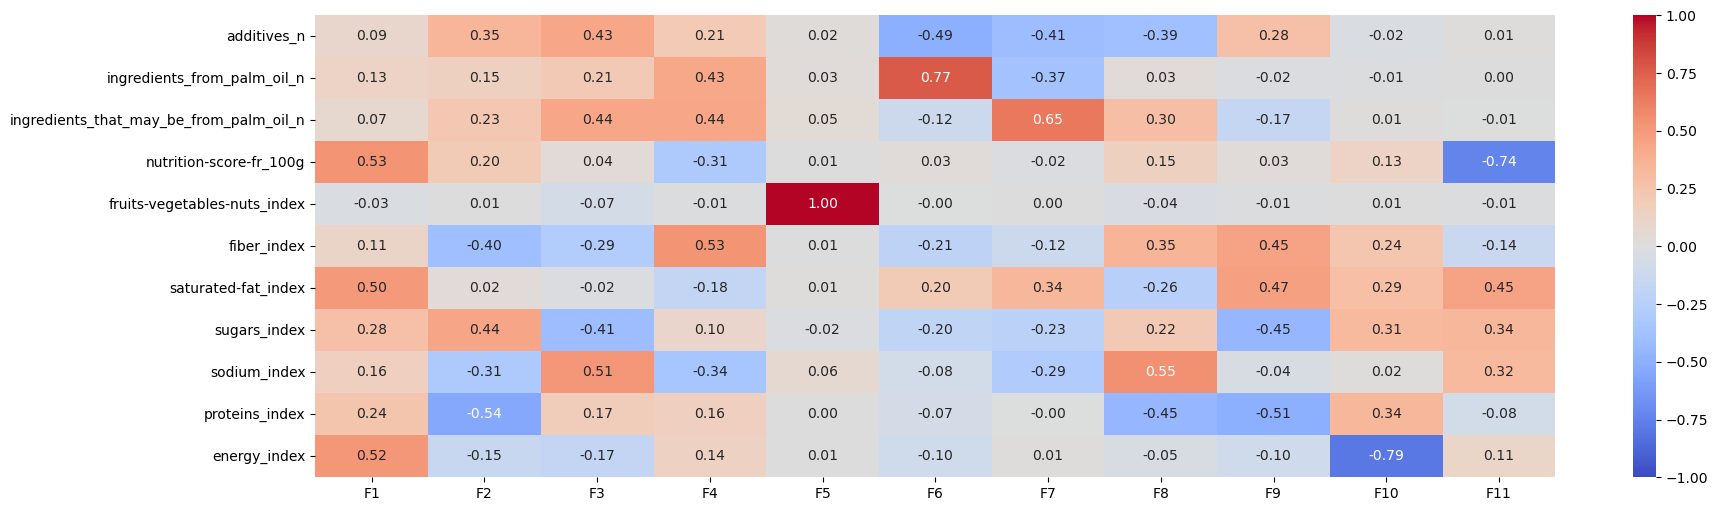

In [34]:
# représentation visuelle
gif, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

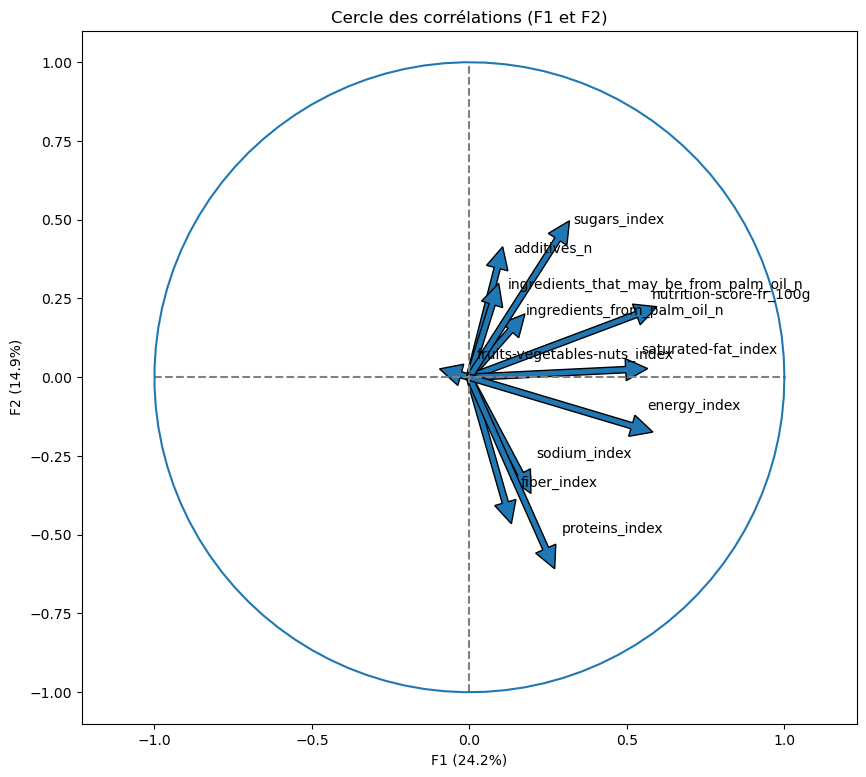

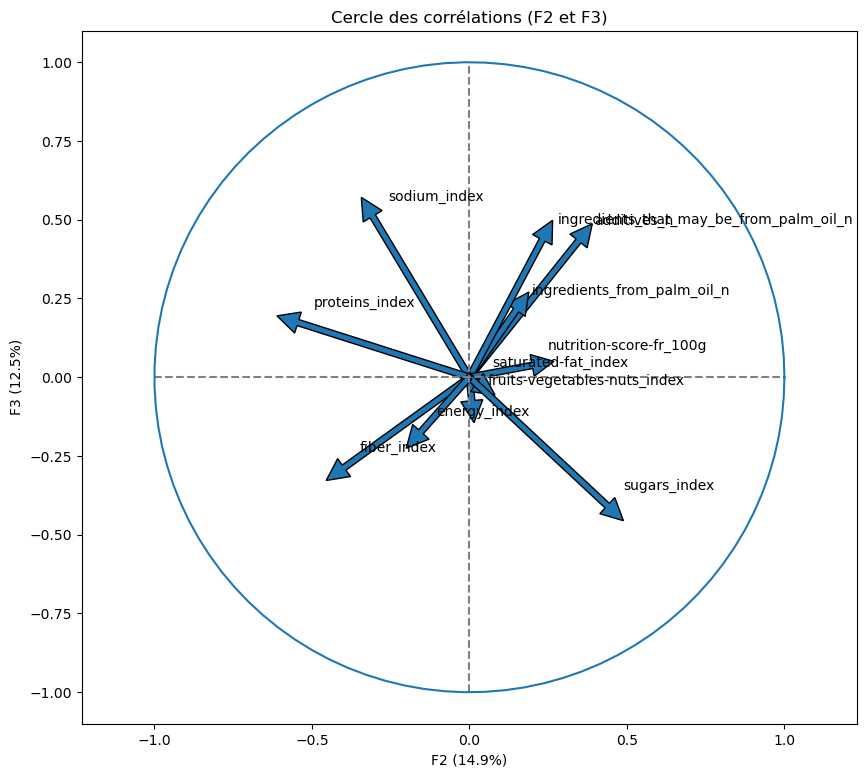

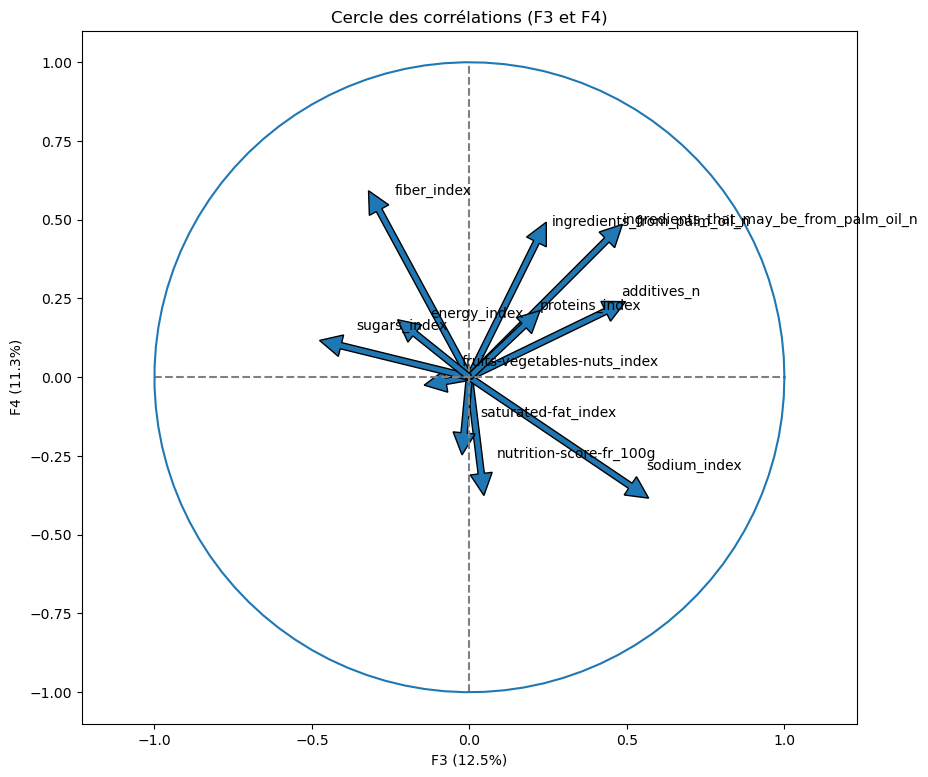

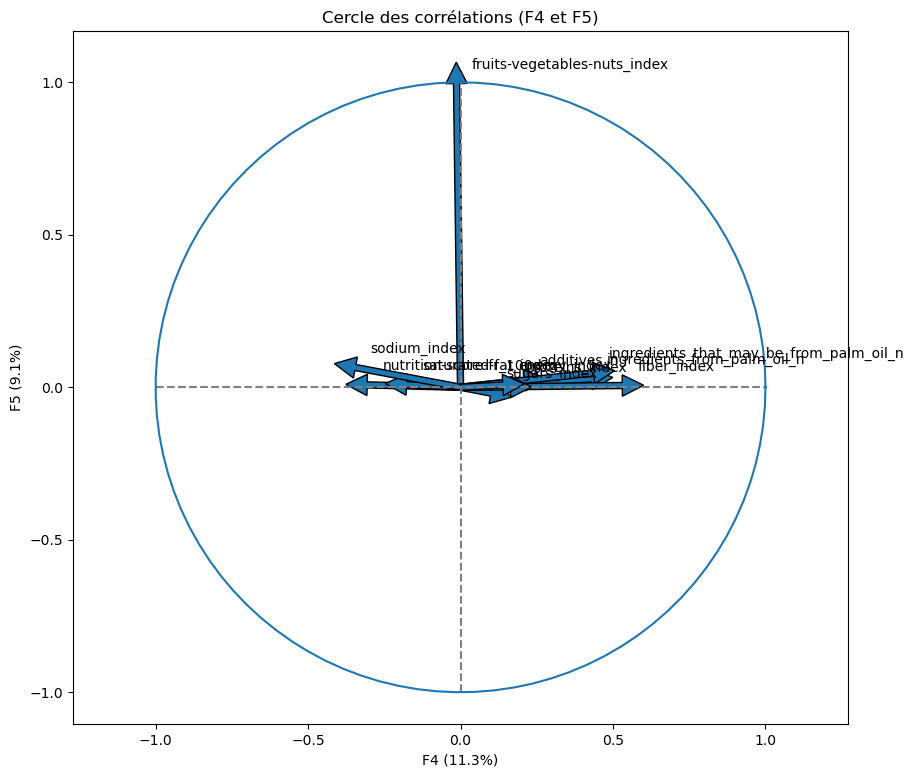

In [35]:
x, y = 0,1
for x, y in [(0, 1), (1, 2), (2, 3), (3, 4)]:
    fig, ax = plt.subplots(figsize=(10, 9))
    for i in range(0, pca.components_.shape[1]):
        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')


    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    plt.axis('equal')
    plt.show(block=False)

In [45]:
# import re
# for index, row in raw_data["additives"].iteritems():
#     if pd.notnull(row):
#         found = re.findall('en\:(.+?) +\]', row)
#         raw_data.at[index, "list_additives_en"] = found
#     else:
#         raw_data.at[index, "list_additives_en"] = np.nan

In [44]:
# import re
# mask = (raw_data["additives"].notnull()) & (raw_data["additives"] != False)
# raw_data.loc[mask, "list_additives_en"] = re.findall('en\:(.+?) +\]', str(raw_data.loc[mask, "additives"]))

In [54]:
import re
dict_additives = {}
for index, row in raw_data["additives"].iteritems():
    if pd.notnull(row):
        found = re.findall('en\:(.+?) +\]', row)
        for add in found:
            if dict_additives.get(add, False):
                dict_additives[add] += 1
            else:
                dict_additives[add] = 1
print("Il y a", len(dict_additives), "additifs différents.")

Il y a 208946 additifs différents.


In [55]:
from operator import itemgetter
dict(sorted(dict_additives.items(), key = itemgetter(1), reverse = True)[:20])

{'salt': 127034,
 'sugar': 103857,
 'water': 87625,
 'oil': 87433,
 'flour': 76756,
 'fd-c': 74160,
 'milk': 51889,
 'e330  -> exists  -- ok': 44809,
 'syrup': 43847,
 'flavor': 42552,
 'powder': 38731,
 'wheat-flour': 37712,
 'starch': 33295,
 'corn-syrup': 32468,
 'e322  -> exists  -- ok': 26787,
 'acid': 25478,
 'vinegar': 23273,
 'flavors': 22740,
 'e101  -> exists  -- ok': 22383,
 'e375  -> exists  -- ok': 22341}